In [128]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [133]:
## load datasets
### WARNING: check the path of files
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [112]:
## Split the data_train to get validations
def train_test_split(X,train_size=0.8,shuffle=True): # Splitted train dataset is size (24000,784) and test dataset is (6000,784)
    border = int(train_size*len(X))
    X_train, X_test = X[:border], X[border:]
    return X_train, X_test

In [113]:
## Split data_train and label_train as well, in order to test the algorithm
split_train, split_test = train_test_split(data_train)
split_label_train, split_label_test = train_test_split(label_train)

In [114]:
## Data preprocessing by PCA for train dataset
def PCAtrain(conponent, data):
    mean = np.mean(data, axis = 0)
    new_data = data - mean
    covMatrix = np.mat(np.cov(new_data, rowvar = 0)) # covariance matrix
    eig_vals, eig_vecs = np.linalg.eig(covMatrix)
    
    index = np.argsort(-eig_vals) # Sort the eigenvalues from large to small
    eig_vecs = eig_vecs[:,index][:,:conponent] # Specify the dimension of dimensionality reduction
    eig_vals = -np.sort(-eig_vals)[:conponent] # Sort the eigenvalues from large to small
    pca_data = np.dot(new_data, eig_vecs) # Low-dimensional feature space data

    recon = pca_data.dot(eig_vecs.T) + mean # Restructure the data

    return pca_data, eig_vecs, recon

In [115]:
## Data preprocessing by PCA for test dataset
def PCAtest(data):
    mean = np.mean(data, axis = 0)
    new_data = data - mean
    pca_data = np.dot(new_data, eig_vecs_train) ###Using eigenvectors from PCAtrain
    
    return pca_data

In [116]:
## Get the datasets processed by PCA
pca_data_train, eig_vecs_train, recon = PCAtrain(40, split_train) # The component is 40
pca_data_test = PCAtest(split_test) 

In [117]:
## Get the closest label
def getLabels(sortedList, label, k): 
    record_label = []

    for m in range(k):
        labels = label[sortedList[m]] # Get k closest items
        record_label.append(labels) # Put these items into this list
  
    maxLabel = max(record_label, key=record_label.count) # Get the most appearing elements in the list

    return maxLabel

In [121]:
## Classifier KNN
def KNN(train, test, label, k):
    result_list = []
    
    for j in range(test.shape[0]):
        current = test[j]
        dist_nearest = []
        for i in range(train.shape[0]):
            dist = np.linalg.norm(current - train[i]) # Calculate the distance
            dist_nearest.append(dist) # Put these dists into this list
            
        sortedDist = np.argsort(dist_nearest) # Sort the distances by size (from large to small)
        
        maxLabel = getLabels(sortedDist, label, k)
    
        result_list.append(maxLabel) # Print out
    
    return result_list

In [122]:
## Get predictions from KNN
knn = KNN(pca_data_train, pca_data_test[0:5000], split_label_train, 12)

In [123]:
## Reput the output file for recheck (if need)
#with h5py.File('./Assignment1/Output/predicted_labels.h5','r') as H:
    #KNN = np.copy(H['Output'])

In [124]:
## Calculate the accuacy of KNN
def accurancyKNN(kn, label):
    count = 0
    
    for i in range(label.shape[0]):
        if kn[i] == label[i]: # if label in kn is same as label list, count +1
            count += 1   
    
    accurancy = count/(label.shape[0]) # Calculate the accurancy
    return accurancy

In [ ]:
## Get the results by percentage
accu = accurancyKNN(knn, split_label_test[0:5000])
print("percent: {:.4%}".format(accu))

In [ ]:
###### WARNING #######
###T his part of function is used to find hyperparameters
### This might need a very long time to print out the results! (Usually few hours!!)
### Run with caution!!!

def findK(train, test, label_train, label_test):
    k_list = []
    acc_result = []
    
    for k in range(1,25):
        result_list = KNN(train, test, label_train, k)
        k_list.append(k)
        acc_list = accurancy(result_list, label_test)
        acc_result.append(acc_list)
    
    return k_list, acc_result

k_list, acc_result = findK(pca_data_train, pca_data_test[0:5000], split_label_train, split_label_test[0:5000])
print(k_list)
print(acc_result)

In [ ]:
## Time cost for finding hyperparameter K
start = time.time()
result = findK(pca_data_train, pca_data_test[0:5000], split_label_train, split_label_test[0:5000])
print("Time cost: ", time.time()-start)

In [219]:
## Result for finding hyperparameter K 
k_list = []
acc_result = []
for k in range(1,25):
    result_list = KNN(pca_data_train, pca_data_test[0:5000], split_label_train, k)
    k_list.append(k)
    acc_list = accurancy(result_list, split_label_test[0:5000])
    acc_result.append(acc_list)

print(k_list)
print(acc_result)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[0.8192, 0.8192, 0.8334, 0.8356, 0.8388, 0.8414, 0.8402, 0.8434, 0.8414, 0.8422, 0.842, 0.8438, 0.842, 0.8416, 0.8392, 0.839, 0.838, 0.839, 0.838, 0.835, 0.8354, 0.8364, 0.8376, 0.8378]


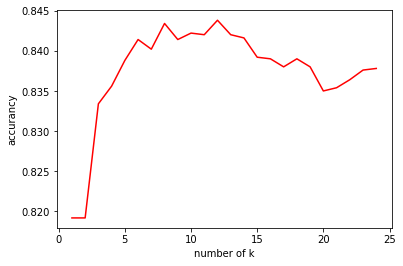

In [239]:
## Draw a plot to show off the relations between accuracy and hyperparameter K
plt.plot(k_list, acc_result, 'r')
plt.xlabel("number of k")
plt.ylabel("accurancy")
plt.show()

In [69]:
## Naive Bayes Algorithm
## Using log-likelihood to calculate priori prob and posterior prob
def NavieBayes(train, label):
    total_count = train.shape[0]
    
    separated = [] # Combine same type items into one list
    prob_list = [] # Calculate prior probability
    sum_list = [] # Sum of extract attribute features by category and counts the times
    predict_list = [] # List of predictions
    
    for classes in np.unique(label):
        same_list = []
        for sample, label_sample in zip(train, label): # Combine the classes with same types
            if label_sample == classes:
                same_list.append(sample)
        
        separated.append(same_list) # Add to the list
        
    for i in separated:
        prob = np.log(len(i) / total_count) # Calculate priori probability
        prob_list.append(prob)
        
    for count in separated:
        sum_count = np.array(count).sum(axis=0) # Counts of how many times the feature appears
        sum_list.append(sum_count)
        
        counts = np.array(sum_list) + 1 # In order to avoid 0 situation (LaPlace)
    
    for j in train:
        feature_prob = np.log(counts / counts.sum(axis=1)[np.newaxis].T) # Calculate posterior probability
        
        predict_prob = (feature_prob * j).sum(axis=1) + prob # Prediction probability
        predict_list.append(predict_prob) # Save into list
        
    final_predict = np.argmax(predict_list, axis=1) # Get the largest(closest) prob to predict the label
    
    return final_predict 

In [39]:
## Get Naive Bayes result predictions
nv = NavieBayes(split_test, split_label_test)

In [40]:
## Calculate the accuracy of NB algorithm
def accurancyNB(kn, label):
    count = 0
    for i in range(label.shape[0]):
        if kn[i] == label[i]:
            count += 1
    
    accurancy = count/(label.shape[0])
    
    return accurancy

In [ ]:
## Final result in percentage format
accu = accurancyNB(nv, split_label_test)
print("percent: {:.4%}".format(accu))

In [105]:
## Output the KNN result list (5000,)
## Check the file path as well
with h5py.File('./Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=knn)